In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [27]:
#load data
df_trading = pd.read_csv('data/all_stock_close_price_from2023-11-15to2023-12-15.csv')
df_broker = pd.read_csv('data/9217_from2023-11-15to2023-12-15_trader_trading.csv')

# 按日期分組，選取每天買進量前二十的股票
top20_buys_daily = df_broker.groupby('date').apply(lambda x: x.sort_values('buy', ascending=False).head(20)).reset_index(drop=True)

# 計算每支股票每天的總買進量
broker_buy_sum = top20_buys_daily.groupby(['stock_id', 'date'])['buy'].sum().reset_index()

# 合併到每日成交資料中
df_combined = pd.merge(df_trading, broker_buy_sum, on=['stock_id', 'date'], how='left')

# 計算買進比例
df_combined['buy_ratio'] = df_combined['buy'] / df_combined['Trading_Volume']

In [28]:
# 對日期進行排序，以便計算隔天價格
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)

# 計算隔天的股價變化
df_combined['next_day_close'] = df_combined.groupby('stock_id')['close'].shift(-1)
df_combined['price_change'] = df_combined['next_day_close'] - df_combined['close']
df_combined['price_change_percentage'] = (df_combined['price_change'] / df_combined['close']) * 100



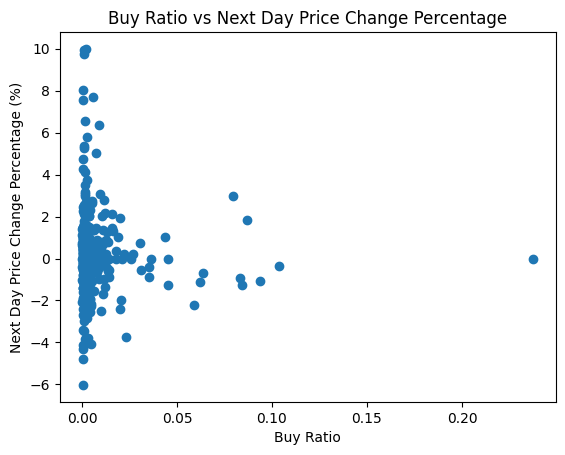

In [29]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 隨機選擇部分點進行標注
sampled_points = df_combined.sample(n=20)
for index, row in sampled_points.iterrows():
    plt.annotate(f"{row['stock_id']} ({row['date']}, {row['price_change_percentage']:.2f}%)",
                 (row['buy_ratio'], row['price_change_percentage']))

plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage')
plt.show()

True
True


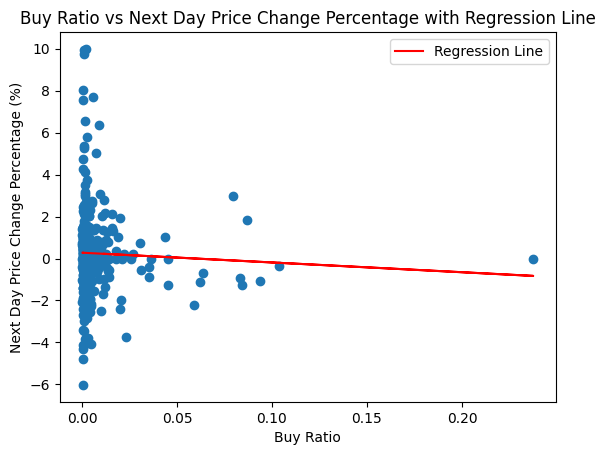

In [33]:

print(df_combined['buy_ratio'].isnull().any())
print(df_combined['price_change_percentage'].isnull().any())

# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 使用numpy計算線性回歸的參數
slope, intercept = np.polyfit(df_combined['buy_ratio'], df_combined['price_change_percentage'], 1)


# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 繪製回歸線
x = np.array(df_combined['buy_ratio'])
plt.plot(x, intercept + slope * x, color='red', label='Regression Line')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage with Regression Line')
plt.legend()

# 顯示圖形
plt.show()
